In [1]:
%%time
import os

import pandas as pd
from pandas.core.groupby import DataFrameGroupBy
from dask.diagnostics import ProgressBar
from tqdm.dask import TqdmCallback

from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env

cb = TqdmCallback(desc="global")
cb.register()

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter

file_system = AzureFileStorageAdapter('data').get_file_storage()

CPU times: total: 4.12 s
Wall time: 8.1 s


In [2]:
def filter_on_existing_thumbnail_path(x: object) -> bool:
	try:
		path = x['thumbnail_path']
		return os.path.exists(path)
	except:
		return False

In [3]:
def get_image_bytes(x: object) -> object:
	try:
		path = x['path']
		data = open(path, 'rb').read()
		return data
	except:
		return None

In [4]:
%%time
extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(extant_data)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21946,10365m3,wallstreetbets,ToiletHandl,"I sold at 32% gain, but it’s still going up.. ...",a screenshote of a tweee of a group of people ...,4cd75ac12563baded80ac7a79152ae1e,/r/wallstreetbets/comments/10365m3/i_sold_at_3...,https://i.redd.it/bv84lwzv43aa1.jpg,4cd75ac12563baded80ac7a79152ae1e.jpg,D:\data\images\wallstreetbets\4cd75ac12563bade...,D:\data\images\wallstreetbets\thumbnail\4cd75a...,True,False
21947,1036071,wallstreetbets,Bethanysteele72,Bite me,a woman in a blue bikinisuit laying on a bed,39a441be43bebb6c64301069c71c2e84,/r/wallstreetbets/comments/1036071/bite_me/,https://i.redd.it/vybemlat33aa1.jpg,39a441be43bebb6c64301069c71c2e84.jpg,D:\data\images\wallstreetbets\39a441be43bebb6c...,D:\data\images\wallstreetbets\thumbnail\39a441...,True,False
21948,1035vqc,wallstreetbets,kevinyyh2020,SPY PUTS GAIN. 100k achieved finally.,a screenshote of a phone showing a screenshote...,a50173fd92b92f08d1f96b6cf921788f,/r/wallstreetbets/comments/1035vqc/spy_puts_ga...,https://i.redd.it/9ctzlozv23aa1.jpg,a50173fd92b92f08d1f96b6cf921788f.jpg,D:\data\images\wallstreetbets\a50173fd92b92f08...,D:\data\images\wallstreetbets\thumbnail\a50173...,True,False
21949,1035nhr,wallstreetbets,ElNinoDelGato,Going short on the SPY again.,a screenshote of a phone showing the options f...,9edbc56e99449ad01b07e632396d18c3,/r/wallstreetbets/comments/1035nhr/going_short...,https://i.redd.it/rojt96f713aa1.jpg,9edbc56e99449ad01b07e632396d18c3.jpg,D:\data\images\wallstreetbets\9edbc56e99449ad0...,D:\data\images\wallstreetbets\thumbnail\9edbc5...,True,False


CPU times: total: 781 ms
Wall time: 1.89 s


CPU times: total: 8.03 s
Wall time: 26.7 s


<Axes: xlabel='subreddit'>

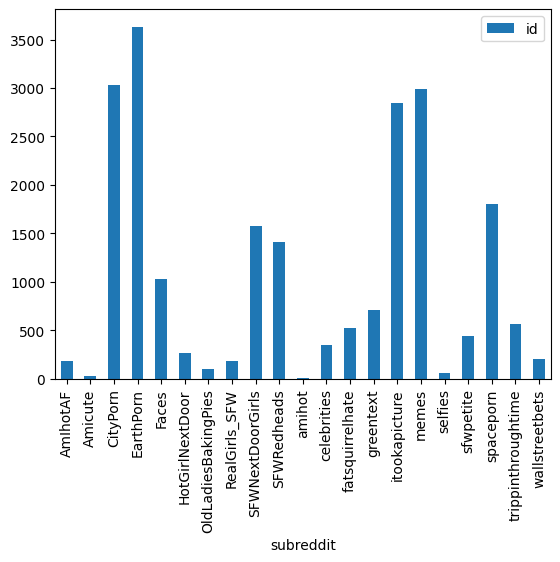

In [5]:
%%time
temp = extant_data.copy()
temp['exists'] = extant_data.apply(lambda x: filter_on_existing_thumbnail_path(x), axis=1)

temp = temp.where(lambda x: x['exists']).dropna(how='all').reset_index(drop=True)
temp = temp.where(lambda x: x['caption'] != "").dropna(how='all').reset_index(drop=True)

grouped: DataFrameGroupBy = temp \
	.where(lambda x: x['exists']) \
	.groupby('subreddit')

grouped.count().plot.bar(y='id')

In [6]:
%%time
display(temp)
temp.to_csv('processed_raw_data.csv', index=False)
file_system.put('processed_raw_data.csv','data/processed_raw_data.csv', overwrite=True)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21946,10365m3,wallstreetbets,ToiletHandl,"I sold at 32% gain, but it’s still going up.. ...",a screenshote of a tweee of a group of people ...,4cd75ac12563baded80ac7a79152ae1e,/r/wallstreetbets/comments/10365m3/i_sold_at_3...,https://i.redd.it/bv84lwzv43aa1.jpg,4cd75ac12563baded80ac7a79152ae1e.jpg,D:\data\images\wallstreetbets\4cd75ac12563bade...,D:\data\images\wallstreetbets\thumbnail\4cd75a...,True,False
21947,1036071,wallstreetbets,Bethanysteele72,Bite me,a woman in a blue bikinisuit laying on a bed,39a441be43bebb6c64301069c71c2e84,/r/wallstreetbets/comments/1036071/bite_me/,https://i.redd.it/vybemlat33aa1.jpg,39a441be43bebb6c64301069c71c2e84.jpg,D:\data\images\wallstreetbets\39a441be43bebb6c...,D:\data\images\wallstreetbets\thumbnail\39a441...,True,False
21948,1035vqc,wallstreetbets,kevinyyh2020,SPY PUTS GAIN. 100k achieved finally.,a screenshote of a phone showing a screenshote...,a50173fd92b92f08d1f96b6cf921788f,/r/wallstreetbets/comments/1035vqc/spy_puts_ga...,https://i.redd.it/9ctzlozv23aa1.jpg,a50173fd92b92f08d1f96b6cf921788f.jpg,D:\data\images\wallstreetbets\a50173fd92b92f08...,D:\data\images\wallstreetbets\thumbnail\a50173...,True,False
21949,1035nhr,wallstreetbets,ElNinoDelGato,Going short on the SPY again.,a screenshote of a phone showing the options f...,9edbc56e99449ad01b07e632396d18c3,/r/wallstreetbets/comments/1035nhr/going_short...,https://i.redd.it/rojt96f713aa1.jpg,9edbc56e99449ad01b07e632396d18c3.jpg,D:\data\images\wallstreetbets\9edbc56e99449ad0...,D:\data\images\wallstreetbets\thumbnail\9edbc5...,True,False


CPU times: total: 1.17 s
Wall time: 4.98 s


[None]

In [7]:
final = pd.read_csv(file_system.open('data/processed_raw_data.csv'))
display(final)
final.to_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21946,10365m3,wallstreetbets,ToiletHandl,"I sold at 32% gain, but it’s still going up.. ...",a screenshote of a tweee of a group of people ...,4cd75ac12563baded80ac7a79152ae1e,/r/wallstreetbets/comments/10365m3/i_sold_at_3...,https://i.redd.it/bv84lwzv43aa1.jpg,4cd75ac12563baded80ac7a79152ae1e.jpg,D:\data\images\wallstreetbets\4cd75ac12563bade...,D:\data\images\wallstreetbets\thumbnail\4cd75a...,True,False
21947,1036071,wallstreetbets,Bethanysteele72,Bite me,a woman in a blue bikinisuit laying on a bed,39a441be43bebb6c64301069c71c2e84,/r/wallstreetbets/comments/1036071/bite_me/,https://i.redd.it/vybemlat33aa1.jpg,39a441be43bebb6c64301069c71c2e84.jpg,D:\data\images\wallstreetbets\39a441be43bebb6c...,D:\data\images\wallstreetbets\thumbnail\39a441...,True,False
21948,1035vqc,wallstreetbets,kevinyyh2020,SPY PUTS GAIN. 100k achieved finally.,a screenshote of a phone showing a screenshote...,a50173fd92b92f08d1f96b6cf921788f,/r/wallstreetbets/comments/1035vqc/spy_puts_ga...,https://i.redd.it/9ctzlozv23aa1.jpg,a50173fd92b92f08d1f96b6cf921788f.jpg,D:\data\images\wallstreetbets\a50173fd92b92f08...,D:\data\images\wallstreetbets\thumbnail\a50173...,True,False
21949,1035nhr,wallstreetbets,ElNinoDelGato,Going short on the SPY again.,a screenshote of a phone showing the options f...,9edbc56e99449ad01b07e632396d18c3,/r/wallstreetbets/comments/1035nhr/going_short...,https://i.redd.it/rojt96f713aa1.jpg,9edbc56e99449ad01b07e632396d18c3.jpg,D:\data\images\wallstreetbets\9edbc56e99449ad0...,D:\data\images\wallstreetbets\thumbnail\9edbc5...,True,False


In [8]:
check = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(check)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21946,10365m3,wallstreetbets,ToiletHandl,"I sold at 32% gain, but it’s still going up.. ...",a screenshote of a tweee of a group of people ...,4cd75ac12563baded80ac7a79152ae1e,/r/wallstreetbets/comments/10365m3/i_sold_at_3...,https://i.redd.it/bv84lwzv43aa1.jpg,4cd75ac12563baded80ac7a79152ae1e.jpg,D:\data\images\wallstreetbets\4cd75ac12563bade...,D:\data\images\wallstreetbets\thumbnail\4cd75a...,True,False
21947,1036071,wallstreetbets,Bethanysteele72,Bite me,a woman in a blue bikinisuit laying on a bed,39a441be43bebb6c64301069c71c2e84,/r/wallstreetbets/comments/1036071/bite_me/,https://i.redd.it/vybemlat33aa1.jpg,39a441be43bebb6c64301069c71c2e84.jpg,D:\data\images\wallstreetbets\39a441be43bebb6c...,D:\data\images\wallstreetbets\thumbnail\39a441...,True,False
21948,1035vqc,wallstreetbets,kevinyyh2020,SPY PUTS GAIN. 100k achieved finally.,a screenshote of a phone showing a screenshote...,a50173fd92b92f08d1f96b6cf921788f,/r/wallstreetbets/comments/1035vqc/spy_puts_ga...,https://i.redd.it/9ctzlozv23aa1.jpg,a50173fd92b92f08d1f96b6cf921788f.jpg,D:\data\images\wallstreetbets\a50173fd92b92f08...,D:\data\images\wallstreetbets\thumbnail\a50173...,True,False
21949,1035nhr,wallstreetbets,ElNinoDelGato,Going short on the SPY again.,a screenshote of a phone showing the options f...,9edbc56e99449ad01b07e632396d18c3,/r/wallstreetbets/comments/1035nhr/going_short...,https://i.redd.it/rojt96f713aa1.jpg,9edbc56e99449ad01b07e632396d18c3.jpg,D:\data\images\wallstreetbets\9edbc56e99449ad0...,D:\data\images\wallstreetbets\thumbnail\9edbc5...,True,False
